In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms (augmentation, normalization etc.)
# transform = transforms.Compose([
#     transforms.Resize((32,32)),     # Resize to standard size
#     transforms.ToTensor(),             # Convert to PyTorch tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize to [-1, 1]
#                          std=[0.5, 0.5, 0.5])
# ])
transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = datasets.ImageFolder(root='/kaggle/input/cnw-patches/kaggle/working/CropAndWeedsPatches', transform=transform)

# Create dataloaders
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [2]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


In [3]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class PatchEmbed(nn.Module):
    """Split image into patches and embed them."""
    
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )
        
    def forward(self, x):
        x = self.proj(x)  # Shape: [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2)  # Shape: [B, embed_dim, n_patches]
        x = x.transpose(1, 2)  # Shape: [B, n_patches, embed_dim]
        return x

In [5]:
class Attention(nn.Module):
    """Multi-head Attention mechanism."""
    
    def __init__(self, dim, num_heads=3, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
    def forward(self, x):
        B, N, C = x.shape  # [batch_size, n_patches + 1, embed_dim]
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each with shape [B, num_heads, N, head_dim]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [B, num_heads, N, N]
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)  # [B, N, C]
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [6]:
class MLP(nn.Module):
    """MLP block."""
    
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [7]:
class Block(nn.Module):
    """Transformer encoder block."""
    
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), out_features=dim, drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [8]:
class ViTTiny(nn.Module):
    """Vision Transformer for 32x32 images."""
    
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=192, 
                 depth=12, num_heads=3, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, 
                  drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)
        ])
        
        # Final normalization and classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        
        # Initialize position embeddings and cls token
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, n_patches, embed_dim]
        
        # Prepend class token
        cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_token, x), dim=1)  # [B, 1 + n_patches, embed_dim]
        
        # Add position embedding
        x = x + self.pos_embed  # [B, 1 + n_patches, embed_dim]
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        return x[:, 0]  # Return only the class token
    
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [9]:
# Example usage
def check():
    # Initialize model
    model = ViTTiny(
        img_size=32,            # Input image size
        patch_size=4,           # Patch size
        in_chans=3,             # Input channels (RGB)
        num_classes=10,         # Number of classes
        embed_dim=128,          # Embedding dimension
        depth=6,               # Number of transformer blocks
        num_heads=2,            # Number of attention heads
        mlp_ratio=4.,           # MLP expansion ratio
        qkv_bias=True,          # Use bias for QKV projection
        drop_rate=0.2,          # Dropout rate
        attn_drop_rate=0.2       # Attention dropout rate
    )
    
    # Create a random batch of images
    x = torch.randn(4, 3, 32, 32)  # [batch_size, channels, height, width]
    
    # Forward pass
    output = model(x)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")  # Should be [batch_size, num_classes]
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

In [10]:
check()

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 10])
Model parameters: 1205898


In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [12]:
def train_vit(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001, 
              weight_decay=1e-4, device=None):
    """
    Train a Vision Transformer model
    
    Args:
        model: The ViT model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        weight_decay: L2 regularization strength
        device: Device to train on ('cuda' or 'cpu')
    
    Returns:
        trained model and training history
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Training on {device}")
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    # Track best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            batch_samples = inputs.size(0)
            running_loss += loss.item() * batch_samples
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += batch_samples
            
            # Update progress bar
            train_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Statistics
                batch_samples = inputs.size(0)
                running_loss += loss.item() * batch_samples
                running_corrects += torch.sum(preds == labels.data).item()
                total_samples += batch_samples
                
                # Update progress bar
                val_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        epoch_val_loss = running_loss / total_samples
        epoch_val_acc = running_corrects / total_samples
        
        # Update learning rate
        scheduler.step()
        
        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        # Track best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{num_epochs} completed in {time_elapsed:.1f}s")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        print("-" * 60)
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot training history
    plot_training_history(history)
    
    return model, history

In [13]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    
    Args:
        history: Dictionary containing training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('vit_training_history.png')
    plt.show()

In [14]:
def evaluate_model(model, test_loader, device=None):
    """
    Evaluate the model on test data
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        device: Device to evaluate on ('cuda' or 'cpu')
    
    Returns:
        test accuracy and confusion matrix
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Evaluating")
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Print results
    print(f"Test Accuracy: {accuracy:.4f}")
    
    return accuracy, (all_preds, all_labels)

In [15]:
model = ViTTiny(
    img_size=32,            # Input image size
    patch_size=4,           # Patch size
    in_chans=3,             # Input channels (RGB)
    num_classes=17,         # Number of classes
    embed_dim=128,          # Embedding dimension
    depth=6,               # Number of transformer blocks
    num_heads=2,            # Number of attention heads
    mlp_ratio=4.,           # MLP expansion ratio
    qkv_bias=True,          # Use bias for QKV projection
    drop_rate=0.2,          # Dropout rate
    attn_drop_rate=0.2       # Attention dropout rate
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training on cuda


Epoch 1/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 1/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1/180 completed in 312.2s
Train Loss: 1.8877, Train Acc: 0.4392
Val Loss: 1.7493, Val Acc: 0.4651
------------------------------------------------------------


Epoch 2/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 2/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2/180 completed in 168.3s
Train Loss: 1.6147, Train Acc: 0.5023
Val Loss: 1.6427, Val Acc: 0.5023
------------------------------------------------------------


Epoch 3/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 3/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3/180 completed in 161.9s
Train Loss: 1.5079, Train Acc: 0.5332
Val Loss: 1.4821, Val Acc: 0.5459
------------------------------------------------------------


Epoch 4/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 4/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4/180 completed in 135.8s
Train Loss: 1.4358, Train Acc: 0.5556
Val Loss: 1.3860, Val Acc: 0.5849
------------------------------------------------------------


Epoch 5/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 5/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5/180 completed in 138.7s
Train Loss: 1.3781, Train Acc: 0.5707
Val Loss: 1.3267, Val Acc: 0.5954
------------------------------------------------------------


Epoch 6/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 6/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6/180 completed in 144.6s
Train Loss: 1.3305, Train Acc: 0.5877
Val Loss: 1.2674, Val Acc: 0.6108
------------------------------------------------------------


Epoch 7/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 7/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7/180 completed in 174.0s
Train Loss: 1.2940, Train Acc: 0.5990
Val Loss: 1.2089, Val Acc: 0.6322
------------------------------------------------------------


Epoch 8/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 8/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8/180 completed in 134.2s
Train Loss: 1.2535, Train Acc: 0.6109
Val Loss: 1.1850, Val Acc: 0.6380
------------------------------------------------------------


Epoch 9/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 9/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9/180 completed in 138.2s
Train Loss: 1.2154, Train Acc: 0.6216
Val Loss: 1.1537, Val Acc: 0.6455
------------------------------------------------------------


Epoch 10/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 10/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10/180 completed in 244.0s
Train Loss: 1.1918, Train Acc: 0.6296
Val Loss: 1.1357, Val Acc: 0.6511
------------------------------------------------------------


Epoch 11/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 11/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11/180 completed in 298.3s
Train Loss: 1.1491, Train Acc: 0.6424
Val Loss: 1.0807, Val Acc: 0.6734
------------------------------------------------------------


Epoch 12/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 12/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12/180 completed in 210.7s
Train Loss: 1.1277, Train Acc: 0.6502
Val Loss: 1.0423, Val Acc: 0.6768
------------------------------------------------------------


Epoch 13/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 13/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13/180 completed in 153.3s
Train Loss: 1.1002, Train Acc: 0.6578
Val Loss: 1.0975, Val Acc: 0.6674
------------------------------------------------------------


Epoch 14/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 14/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14/180 completed in 155.2s
Train Loss: 1.0728, Train Acc: 0.6676
Val Loss: 1.0450, Val Acc: 0.6822
------------------------------------------------------------


Epoch 15/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 15/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15/180 completed in 144.5s
Train Loss: 1.0457, Train Acc: 0.6757
Val Loss: 0.9829, Val Acc: 0.7017
------------------------------------------------------------


Epoch 16/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 16/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16/180 completed in 151.7s
Train Loss: 1.0232, Train Acc: 0.6821
Val Loss: 0.9547, Val Acc: 0.7113
------------------------------------------------------------


Epoch 17/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 17/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17/180 completed in 142.2s
Train Loss: 1.0090, Train Acc: 0.6835
Val Loss: 0.9655, Val Acc: 0.7062
------------------------------------------------------------


Epoch 18/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 18/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18/180 completed in 148.7s
Train Loss: 0.9888, Train Acc: 0.6919
Val Loss: 0.9395, Val Acc: 0.7136
------------------------------------------------------------


Epoch 19/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 19/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19/180 completed in 135.0s
Train Loss: 0.9629, Train Acc: 0.7005
Val Loss: 0.9259, Val Acc: 0.7210
------------------------------------------------------------


Epoch 20/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 20/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20/180 completed in 135.7s
Train Loss: 0.9440, Train Acc: 0.7090
Val Loss: 0.9233, Val Acc: 0.7199
------------------------------------------------------------


Epoch 21/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 21/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21/180 completed in 139.2s
Train Loss: 0.9293, Train Acc: 0.7108
Val Loss: 0.9022, Val Acc: 0.7284
------------------------------------------------------------


Epoch 22/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 22/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22/180 completed in 133.6s
Train Loss: 0.9144, Train Acc: 0.7146
Val Loss: 0.9010, Val Acc: 0.7283
------------------------------------------------------------


Epoch 23/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 23/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23/180 completed in 132.3s
Train Loss: 0.8991, Train Acc: 0.7231
Val Loss: 0.8769, Val Acc: 0.7346
------------------------------------------------------------


Epoch 24/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 24/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24/180 completed in 147.2s
Train Loss: 0.8873, Train Acc: 0.7232
Val Loss: 0.8562, Val Acc: 0.7425
------------------------------------------------------------


Epoch 25/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 25/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25/180 completed in 133.8s
Train Loss: 0.8725, Train Acc: 0.7300
Val Loss: 0.8704, Val Acc: 0.7359
------------------------------------------------------------


Epoch 26/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 26/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26/180 completed in 135.6s
Train Loss: 0.8652, Train Acc: 0.7308
Val Loss: 0.9072, Val Acc: 0.7288
------------------------------------------------------------


Epoch 27/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 27/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27/180 completed in 144.4s
Train Loss: 0.8533, Train Acc: 0.7332
Val Loss: 0.8504, Val Acc: 0.7444
------------------------------------------------------------


Epoch 28/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 28/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28/180 completed in 132.6s
Train Loss: 0.8382, Train Acc: 0.7398
Val Loss: 0.8721, Val Acc: 0.7392
------------------------------------------------------------


Epoch 29/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 29/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29/180 completed in 135.0s
Train Loss: 0.8319, Train Acc: 0.7402
Val Loss: 0.8113, Val Acc: 0.7577
------------------------------------------------------------


Epoch 30/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 30/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30/180 completed in 137.2s
Train Loss: 0.8163, Train Acc: 0.7463
Val Loss: 0.8034, Val Acc: 0.7582
------------------------------------------------------------


Epoch 31/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 31/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 31/180 completed in 135.0s
Train Loss: 0.8087, Train Acc: 0.7477
Val Loss: 0.8013, Val Acc: 0.7634
------------------------------------------------------------


Epoch 32/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 32/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 32/180 completed in 131.0s
Train Loss: 0.8035, Train Acc: 0.7488
Val Loss: 0.8211, Val Acc: 0.7536
------------------------------------------------------------


Epoch 33/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 33/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 33/180 completed in 155.2s
Train Loss: 0.7915, Train Acc: 0.7528
Val Loss: 0.8069, Val Acc: 0.7555
------------------------------------------------------------


Epoch 34/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 34/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 34/180 completed in 158.1s
Train Loss: 0.7866, Train Acc: 0.7524
Val Loss: 0.7882, Val Acc: 0.7660
------------------------------------------------------------


Epoch 35/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 35/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 35/180 completed in 135.8s
Train Loss: 0.7742, Train Acc: 0.7584
Val Loss: 0.7948, Val Acc: 0.7604
------------------------------------------------------------


Epoch 36/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 36/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 36/180 completed in 132.6s
Train Loss: 0.7605, Train Acc: 0.7630
Val Loss: 0.7632, Val Acc: 0.7699
------------------------------------------------------------


Epoch 37/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 37/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 37/180 completed in 131.1s
Train Loss: 0.7554, Train Acc: 0.7654
Val Loss: 0.7974, Val Acc: 0.7608
------------------------------------------------------------


Epoch 38/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 38/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 38/180 completed in 130.9s
Train Loss: 0.7416, Train Acc: 0.7677
Val Loss: 0.7590, Val Acc: 0.7742
------------------------------------------------------------


Epoch 39/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 39/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 39/180 completed in 170.0s
Train Loss: 0.7394, Train Acc: 0.7669
Val Loss: 0.7645, Val Acc: 0.7707
------------------------------------------------------------


Epoch 40/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 40/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 40/180 completed in 156.3s
Train Loss: 0.7325, Train Acc: 0.7712
Val Loss: 0.7414, Val Acc: 0.7805
------------------------------------------------------------


Epoch 41/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 41/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 41/180 completed in 131.9s
Train Loss: 0.7221, Train Acc: 0.7747
Val Loss: 0.7431, Val Acc: 0.7783
------------------------------------------------------------


Epoch 42/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 42/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 42/180 completed in 128.3s
Train Loss: 0.7165, Train Acc: 0.7745
Val Loss: 0.7367, Val Acc: 0.7781
------------------------------------------------------------


Epoch 43/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 43/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 43/180 completed in 127.9s
Train Loss: 0.7049, Train Acc: 0.7795
Val Loss: 0.7862, Val Acc: 0.7656
------------------------------------------------------------


Epoch 44/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 44/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 44/180 completed in 133.1s
Train Loss: 0.7013, Train Acc: 0.7783
Val Loss: 0.7461, Val Acc: 0.7776
------------------------------------------------------------


Epoch 45/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 45/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 45/180 completed in 130.7s
Train Loss: 0.6943, Train Acc: 0.7821
Val Loss: 0.7448, Val Acc: 0.7803
------------------------------------------------------------


Epoch 46/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 46/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 46/180 completed in 130.4s
Train Loss: 0.6840, Train Acc: 0.7851
Val Loss: 0.7325, Val Acc: 0.7854
------------------------------------------------------------


Epoch 47/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 47/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 47/180 completed in 129.2s
Train Loss: 0.6767, Train Acc: 0.7858
Val Loss: 0.7203, Val Acc: 0.7852
------------------------------------------------------------


Epoch 48/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 48/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 48/180 completed in 142.5s
Train Loss: 0.6758, Train Acc: 0.7888
Val Loss: 0.7374, Val Acc: 0.7850
------------------------------------------------------------


Epoch 49/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 49/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 49/180 completed in 134.4s
Train Loss: 0.6648, Train Acc: 0.7908
Val Loss: 0.7445, Val Acc: 0.7806
------------------------------------------------------------


Epoch 50/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 50/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 50/180 completed in 133.0s
Train Loss: 0.6583, Train Acc: 0.7934
Val Loss: 0.7552, Val Acc: 0.7773
------------------------------------------------------------


Epoch 51/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 51/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 51/180 completed in 130.9s
Train Loss: 0.6581, Train Acc: 0.7919
Val Loss: 0.7124, Val Acc: 0.7904
------------------------------------------------------------


Epoch 52/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 52/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 52/180 completed in 148.8s
Train Loss: 0.6454, Train Acc: 0.7965
Val Loss: 0.7291, Val Acc: 0.7866
------------------------------------------------------------


Epoch 53/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 53/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 53/180 completed in 143.8s
Train Loss: 0.6410, Train Acc: 0.7990
Val Loss: 0.7293, Val Acc: 0.7881
------------------------------------------------------------


Epoch 54/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 54/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 54/180 completed in 131.4s
Train Loss: 0.6370, Train Acc: 0.7984
Val Loss: 0.7198, Val Acc: 0.7939
------------------------------------------------------------


Epoch 55/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 55/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 55/180 completed in 141.7s
Train Loss: 0.6281, Train Acc: 0.8017
Val Loss: 0.7402, Val Acc: 0.7832
------------------------------------------------------------


Epoch 56/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 56/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 56/180 completed in 140.6s
Train Loss: 0.6197, Train Acc: 0.8039
Val Loss: 0.7030, Val Acc: 0.7899
------------------------------------------------------------


Epoch 57/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 57/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 57/180 completed in 137.5s
Train Loss: 0.6147, Train Acc: 0.8060
Val Loss: 0.7297, Val Acc: 0.7834
------------------------------------------------------------


Epoch 58/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 58/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 58/180 completed in 145.5s
Train Loss: 0.6121, Train Acc: 0.8051
Val Loss: 0.6911, Val Acc: 0.8011
------------------------------------------------------------


Epoch 59/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 59/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 59/180 completed in 182.8s
Train Loss: 0.6123, Train Acc: 0.8061
Val Loss: 0.7075, Val Acc: 0.7970
------------------------------------------------------------


Epoch 60/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 60/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 60/180 completed in 137.1s
Train Loss: 0.6048, Train Acc: 0.8084
Val Loss: 0.7338, Val Acc: 0.7902
------------------------------------------------------------


Epoch 61/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 61/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 61/180 completed in 133.6s
Train Loss: 0.5916, Train Acc: 0.8111
Val Loss: 0.7275, Val Acc: 0.7912
------------------------------------------------------------


Epoch 62/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 62/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 62/180 completed in 133.3s
Train Loss: 0.5869, Train Acc: 0.8119
Val Loss: 0.7100, Val Acc: 0.7968
------------------------------------------------------------


Epoch 63/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 63/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 63/180 completed in 136.4s
Train Loss: 0.5809, Train Acc: 0.8150
Val Loss: 0.6880, Val Acc: 0.8027
------------------------------------------------------------


Epoch 64/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 64/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 64/180 completed in 136.7s
Train Loss: 0.5796, Train Acc: 0.8151
Val Loss: 0.7149, Val Acc: 0.7931
------------------------------------------------------------


Epoch 65/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 65/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 65/180 completed in 139.3s
Train Loss: 0.5727, Train Acc: 0.8163
Val Loss: 0.6912, Val Acc: 0.8039
------------------------------------------------------------


Epoch 66/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 66/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 66/180 completed in 148.0s
Train Loss: 0.5681, Train Acc: 0.8196
Val Loss: 0.7006, Val Acc: 0.7964
------------------------------------------------------------


Epoch 67/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 67/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 67/180 completed in 158.3s
Train Loss: 0.5670, Train Acc: 0.8178
Val Loss: 0.6939, Val Acc: 0.8009
------------------------------------------------------------


Epoch 68/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 68/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 68/180 completed in 147.3s
Train Loss: 0.5574, Train Acc: 0.8232
Val Loss: 0.6943, Val Acc: 0.7985
------------------------------------------------------------


Epoch 69/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 69/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 69/180 completed in 143.4s
Train Loss: 0.5495, Train Acc: 0.8242
Val Loss: 0.7092, Val Acc: 0.7969
------------------------------------------------------------


Epoch 70/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 70/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 70/180 completed in 132.4s
Train Loss: 0.5436, Train Acc: 0.8259
Val Loss: 0.6850, Val Acc: 0.8053
------------------------------------------------------------


Epoch 71/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 71/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 71/180 completed in 130.6s
Train Loss: 0.5426, Train Acc: 0.8258
Val Loss: 0.6875, Val Acc: 0.8085
------------------------------------------------------------


Epoch 72/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 72/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 72/180 completed in 134.5s
Train Loss: 0.5356, Train Acc: 0.8271
Val Loss: 0.6621, Val Acc: 0.8080
------------------------------------------------------------


Epoch 73/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 73/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 73/180 completed in 131.5s
Train Loss: 0.5293, Train Acc: 0.8309
Val Loss: 0.6949, Val Acc: 0.8051
------------------------------------------------------------


Epoch 74/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 74/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 74/180 completed in 132.1s
Train Loss: 0.5284, Train Acc: 0.8306
Val Loss: 0.7091, Val Acc: 0.8038
------------------------------------------------------------


Epoch 75/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 75/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 75/180 completed in 134.1s
Train Loss: 0.5224, Train Acc: 0.8322
Val Loss: 0.6819, Val Acc: 0.8061
------------------------------------------------------------


Epoch 76/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 76/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 76/180 completed in 134.0s
Train Loss: 0.5142, Train Acc: 0.8336
Val Loss: 0.6703, Val Acc: 0.8073
------------------------------------------------------------


Epoch 77/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 77/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 77/180 completed in 143.2s
Train Loss: 0.5070, Train Acc: 0.8350
Val Loss: 0.7062, Val Acc: 0.8012
------------------------------------------------------------


Epoch 78/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 78/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 78/180 completed in 140.7s
Train Loss: 0.5036, Train Acc: 0.8398
Val Loss: 0.6752, Val Acc: 0.8138
------------------------------------------------------------


Epoch 79/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 79/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 79/180 completed in 152.0s
Train Loss: 0.4991, Train Acc: 0.8392
Val Loss: 0.6696, Val Acc: 0.8134
------------------------------------------------------------


Epoch 80/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 80/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 80/180 completed in 142.7s
Train Loss: 0.4983, Train Acc: 0.8393
Val Loss: 0.7210, Val Acc: 0.7984
------------------------------------------------------------


Epoch 81/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 81/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 81/180 completed in 144.2s
Train Loss: 0.4863, Train Acc: 0.8439
Val Loss: 0.6810, Val Acc: 0.8113
------------------------------------------------------------


Epoch 82/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 82/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 82/180 completed in 148.9s
Train Loss: 0.4878, Train Acc: 0.8418
Val Loss: 0.6709, Val Acc: 0.8189
------------------------------------------------------------


Epoch 83/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 83/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 83/180 completed in 129.9s
Train Loss: 0.4814, Train Acc: 0.8451
Val Loss: 0.6898, Val Acc: 0.8070
------------------------------------------------------------


Epoch 84/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 84/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 84/180 completed in 130.6s
Train Loss: 0.4744, Train Acc: 0.8467
Val Loss: 0.6738, Val Acc: 0.8111
------------------------------------------------------------


Epoch 85/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 85/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 85/180 completed in 133.5s
Train Loss: 0.4690, Train Acc: 0.8479
Val Loss: 0.7067, Val Acc: 0.8063
------------------------------------------------------------


Epoch 86/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 86/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 86/180 completed in 134.4s
Train Loss: 0.4681, Train Acc: 0.8472
Val Loss: 0.6702, Val Acc: 0.8158
------------------------------------------------------------


Epoch 87/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 87/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 87/180 completed in 132.7s
Train Loss: 0.4618, Train Acc: 0.8500
Val Loss: 0.6896, Val Acc: 0.8079
------------------------------------------------------------


Epoch 88/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 88/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 88/180 completed in 136.4s
Train Loss: 0.4594, Train Acc: 0.8515
Val Loss: 0.6606, Val Acc: 0.8193
------------------------------------------------------------


Epoch 89/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 89/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 89/180 completed in 150.6s
Train Loss: 0.4561, Train Acc: 0.8522
Val Loss: 0.6776, Val Acc: 0.8153
------------------------------------------------------------


Epoch 90/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 90/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 90/180 completed in 136.9s
Train Loss: 0.4518, Train Acc: 0.8545
Val Loss: 0.6806, Val Acc: 0.8121
------------------------------------------------------------


Epoch 91/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 91/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 91/180 completed in 134.5s
Train Loss: 0.4429, Train Acc: 0.8570
Val Loss: 0.6781, Val Acc: 0.8142
------------------------------------------------------------


Epoch 92/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 92/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 92/180 completed in 133.3s
Train Loss: 0.4381, Train Acc: 0.8570
Val Loss: 0.6870, Val Acc: 0.8088
------------------------------------------------------------


Epoch 93/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 93/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 93/180 completed in 134.9s
Train Loss: 0.4376, Train Acc: 0.8564
Val Loss: 0.6792, Val Acc: 0.8148
------------------------------------------------------------


Epoch 94/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 94/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 94/180 completed in 137.0s
Train Loss: 0.4332, Train Acc: 0.8589
Val Loss: 0.6818, Val Acc: 0.8135
------------------------------------------------------------


Epoch 95/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 95/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 95/180 completed in 134.8s
Train Loss: 0.4283, Train Acc: 0.8604
Val Loss: 0.6841, Val Acc: 0.8178
------------------------------------------------------------


Epoch 96/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 96/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 96/180 completed in 135.5s
Train Loss: 0.4225, Train Acc: 0.8629
Val Loss: 0.6678, Val Acc: 0.8186
------------------------------------------------------------


Epoch 97/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 97/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 97/180 completed in 165.7s
Train Loss: 0.4168, Train Acc: 0.8634
Val Loss: 0.6895, Val Acc: 0.8143
------------------------------------------------------------


Epoch 98/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 98/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 98/180 completed in 136.5s
Train Loss: 0.4124, Train Acc: 0.8656
Val Loss: 0.7004, Val Acc: 0.8100
------------------------------------------------------------


Epoch 99/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 99/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 99/180 completed in 138.8s
Train Loss: 0.4141, Train Acc: 0.8652
Val Loss: 0.6946, Val Acc: 0.8135
------------------------------------------------------------


Epoch 100/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 100/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 100/180 completed in 139.1s
Train Loss: 0.4140, Train Acc: 0.8635
Val Loss: 0.6798, Val Acc: 0.8176
------------------------------------------------------------


Epoch 101/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 101/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 101/180 completed in 145.2s
Train Loss: 0.4029, Train Acc: 0.8672
Val Loss: 0.6921, Val Acc: 0.8145
------------------------------------------------------------


Epoch 102/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 102/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 102/180 completed in 145.2s
Train Loss: 0.4049, Train Acc: 0.8670
Val Loss: 0.7041, Val Acc: 0.8146
------------------------------------------------------------


Epoch 103/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 103/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 103/180 completed in 139.5s
Train Loss: 0.3958, Train Acc: 0.8696
Val Loss: 0.7181, Val Acc: 0.8086
------------------------------------------------------------


Epoch 104/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 104/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 104/180 completed in 139.6s
Train Loss: 0.3944, Train Acc: 0.8694
Val Loss: 0.7091, Val Acc: 0.8123
------------------------------------------------------------


Epoch 105/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 105/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 105/180 completed in 139.8s
Train Loss: 0.3922, Train Acc: 0.8698
Val Loss: 0.6959, Val Acc: 0.8164
------------------------------------------------------------


Epoch 106/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 106/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 106/180 completed in 138.2s
Train Loss: 0.3848, Train Acc: 0.8737
Val Loss: 0.7082, Val Acc: 0.8131
------------------------------------------------------------


Epoch 107/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 107/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 107/180 completed in 141.2s
Train Loss: 0.3798, Train Acc: 0.8748
Val Loss: 0.7200, Val Acc: 0.8133
------------------------------------------------------------


Epoch 108/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 108/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 108/180 completed in 142.0s
Train Loss: 0.3789, Train Acc: 0.8755
Val Loss: 0.7157, Val Acc: 0.8095
------------------------------------------------------------


Epoch 109/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 109/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 109/180 completed in 136.5s
Train Loss: 0.3758, Train Acc: 0.8746
Val Loss: 0.7002, Val Acc: 0.8141
------------------------------------------------------------


Epoch 110/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 110/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 110/180 completed in 141.1s
Train Loss: 0.3679, Train Acc: 0.8781
Val Loss: 0.6744, Val Acc: 0.8245
------------------------------------------------------------


Epoch 111/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 111/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 111/180 completed in 140.5s
Train Loss: 0.3670, Train Acc: 0.8780
Val Loss: 0.6996, Val Acc: 0.8175
------------------------------------------------------------


Epoch 112/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 112/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 112/180 completed in 138.0s
Train Loss: 0.3639, Train Acc: 0.8793
Val Loss: 0.7094, Val Acc: 0.8152
------------------------------------------------------------


Epoch 113/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 113/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 113/180 completed in 136.3s
Train Loss: 0.3643, Train Acc: 0.8803
Val Loss: 0.7098, Val Acc: 0.8182
------------------------------------------------------------


Epoch 114/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 114/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 114/180 completed in 184.3s
Train Loss: 0.3518, Train Acc: 0.8837
Val Loss: 0.7159, Val Acc: 0.8183
------------------------------------------------------------


Epoch 115/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 115/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 115/180 completed in 136.8s
Train Loss: 0.3505, Train Acc: 0.8830
Val Loss: 0.7172, Val Acc: 0.8173
------------------------------------------------------------


Epoch 116/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 116/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 116/180 completed in 136.7s
Train Loss: 0.3547, Train Acc: 0.8807
Val Loss: 0.7145, Val Acc: 0.8143
------------------------------------------------------------


Epoch 117/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 117/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 117/180 completed in 141.5s
Train Loss: 0.3456, Train Acc: 0.8851
Val Loss: 0.7317, Val Acc: 0.8138
------------------------------------------------------------


Epoch 118/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 118/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 118/180 completed in 138.8s
Train Loss: 0.3389, Train Acc: 0.8870
Val Loss: 0.7320, Val Acc: 0.8177
------------------------------------------------------------


Epoch 119/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 119/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 119/180 completed in 149.8s
Train Loss: 0.3411, Train Acc: 0.8869
Val Loss: 0.7376, Val Acc: 0.8121
------------------------------------------------------------


Epoch 120/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 120/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 120/180 completed in 134.5s
Train Loss: 0.3337, Train Acc: 0.8883
Val Loss: 0.7067, Val Acc: 0.8194
------------------------------------------------------------


Epoch 121/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 121/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 121/180 completed in 132.7s
Train Loss: 0.3308, Train Acc: 0.8891
Val Loss: 0.7389, Val Acc: 0.8158
------------------------------------------------------------


Epoch 122/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 122/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 122/180 completed in 133.9s
Train Loss: 0.3309, Train Acc: 0.8894
Val Loss: 0.7442, Val Acc: 0.8153
------------------------------------------------------------


Epoch 123/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 123/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 123/180 completed in 130.0s
Train Loss: 0.3270, Train Acc: 0.8910
Val Loss: 0.7478, Val Acc: 0.8130
------------------------------------------------------------


Epoch 124/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 124/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 124/180 completed in 130.1s
Train Loss: 0.3194, Train Acc: 0.8924
Val Loss: 0.7369, Val Acc: 0.8158
------------------------------------------------------------


Epoch 125/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 125/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 125/180 completed in 129.7s
Train Loss: 0.3218, Train Acc: 0.8917
Val Loss: 0.7334, Val Acc: 0.8142
------------------------------------------------------------


Epoch 126/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 126/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 126/180 completed in 129.8s
Train Loss: 0.3171, Train Acc: 0.8947
Val Loss: 0.7349, Val Acc: 0.8176
------------------------------------------------------------


Epoch 127/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 127/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 127/180 completed in 130.0s
Train Loss: 0.3138, Train Acc: 0.8940
Val Loss: 0.7312, Val Acc: 0.8192
------------------------------------------------------------


Epoch 128/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 128/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 128/180 completed in 143.3s
Train Loss: 0.3129, Train Acc: 0.8954
Val Loss: 0.7490, Val Acc: 0.8184
------------------------------------------------------------


Epoch 129/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 129/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 129/180 completed in 134.5s
Train Loss: 0.3109, Train Acc: 0.8956
Val Loss: 0.7436, Val Acc: 0.8182
------------------------------------------------------------


Epoch 130/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 130/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 130/180 completed in 143.0s
Train Loss: 0.3076, Train Acc: 0.8973
Val Loss: 0.7395, Val Acc: 0.8188
------------------------------------------------------------


Epoch 131/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 131/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 131/180 completed in 134.4s
Train Loss: 0.3036, Train Acc: 0.8978
Val Loss: 0.7439, Val Acc: 0.8201
------------------------------------------------------------


Epoch 132/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 132/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 132/180 completed in 136.3s
Train Loss: 0.3027, Train Acc: 0.8993
Val Loss: 0.7304, Val Acc: 0.8224
------------------------------------------------------------


Epoch 133/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 133/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 133/180 completed in 134.4s
Train Loss: 0.2959, Train Acc: 0.8999
Val Loss: 0.7592, Val Acc: 0.8143
------------------------------------------------------------


Epoch 134/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 134/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 134/180 completed in 191.6s
Train Loss: 0.2962, Train Acc: 0.9012
Val Loss: 0.7425, Val Acc: 0.8206
------------------------------------------------------------


Epoch 135/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 135/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 135/180 completed in 133.9s
Train Loss: 0.2958, Train Acc: 0.8999
Val Loss: 0.7623, Val Acc: 0.8190
------------------------------------------------------------


Epoch 136/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 136/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 136/180 completed in 131.7s
Train Loss: 0.2922, Train Acc: 0.9016
Val Loss: 0.7482, Val Acc: 0.8188
------------------------------------------------------------


Epoch 137/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 137/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 137/180 completed in 134.3s
Train Loss: 0.2898, Train Acc: 0.9033
Val Loss: 0.7633, Val Acc: 0.8138
------------------------------------------------------------


Epoch 138/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 138/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 138/180 completed in 137.5s
Train Loss: 0.2861, Train Acc: 0.9045
Val Loss: 0.7699, Val Acc: 0.8149
------------------------------------------------------------


Epoch 139/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 139/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 139/180 completed in 139.4s
Train Loss: 0.2854, Train Acc: 0.9034
Val Loss: 0.7655, Val Acc: 0.8165
------------------------------------------------------------


Epoch 140/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 140/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 140/180 completed in 133.0s
Train Loss: 0.2797, Train Acc: 0.9058
Val Loss: 0.7593, Val Acc: 0.8181
------------------------------------------------------------


Epoch 141/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 141/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 141/180 completed in 134.0s
Train Loss: 0.2816, Train Acc: 0.9044
Val Loss: 0.7809, Val Acc: 0.8125
------------------------------------------------------------


Epoch 142/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 142/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 142/180 completed in 134.0s
Train Loss: 0.2784, Train Acc: 0.9060
Val Loss: 0.7514, Val Acc: 0.8187
------------------------------------------------------------


Epoch 143/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 143/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 143/180 completed in 133.3s
Train Loss: 0.2753, Train Acc: 0.9062
Val Loss: 0.7586, Val Acc: 0.8195
------------------------------------------------------------


Epoch 144/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 144/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 144/180 completed in 132.2s
Train Loss: 0.2724, Train Acc: 0.9080
Val Loss: 0.7571, Val Acc: 0.8207
------------------------------------------------------------


Epoch 145/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 145/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 145/180 completed in 136.0s
Train Loss: 0.2710, Train Acc: 0.9086
Val Loss: 0.7697, Val Acc: 0.8177
------------------------------------------------------------


Epoch 146/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 146/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 146/180 completed in 130.9s
Train Loss: 0.2709, Train Acc: 0.9091
Val Loss: 0.7691, Val Acc: 0.8160
------------------------------------------------------------


Epoch 147/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 147/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 147/180 completed in 132.8s
Train Loss: 0.2656, Train Acc: 0.9092
Val Loss: 0.7800, Val Acc: 0.8166
------------------------------------------------------------


Epoch 148/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 148/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 148/180 completed in 136.8s
Train Loss: 0.2661, Train Acc: 0.9101
Val Loss: 0.7814, Val Acc: 0.8153
------------------------------------------------------------


Epoch 149/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 149/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 149/180 completed in 153.3s
Train Loss: 0.2663, Train Acc: 0.9097
Val Loss: 0.7744, Val Acc: 0.8196
------------------------------------------------------------


Epoch 150/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 150/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 150/180 completed in 178.2s
Train Loss: 0.2635, Train Acc: 0.9103
Val Loss: 0.7774, Val Acc: 0.8170
------------------------------------------------------------


Epoch 151/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 151/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 151/180 completed in 135.4s
Train Loss: 0.2654, Train Acc: 0.9108
Val Loss: 0.7776, Val Acc: 0.8203
------------------------------------------------------------


Epoch 152/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 152/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 152/180 completed in 135.7s
Train Loss: 0.2636, Train Acc: 0.9117
Val Loss: 0.7865, Val Acc: 0.8188
------------------------------------------------------------


Epoch 153/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 153/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 153/180 completed in 139.5s
Train Loss: 0.2572, Train Acc: 0.9128
Val Loss: 0.7823, Val Acc: 0.8194
------------------------------------------------------------


Epoch 154/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 154/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 154/180 completed in 134.8s
Train Loss: 0.2548, Train Acc: 0.9134
Val Loss: 0.7821, Val Acc: 0.8166
------------------------------------------------------------


Epoch 155/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 155/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 155/180 completed in 136.6s
Train Loss: 0.2580, Train Acc: 0.9124
Val Loss: 0.7873, Val Acc: 0.8162
------------------------------------------------------------


Epoch 156/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 156/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 156/180 completed in 134.1s
Train Loss: 0.2545, Train Acc: 0.9141
Val Loss: 0.7748, Val Acc: 0.8214
------------------------------------------------------------


Epoch 157/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 157/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 157/180 completed in 131.6s
Train Loss: 0.2582, Train Acc: 0.9119
Val Loss: 0.7757, Val Acc: 0.8189
------------------------------------------------------------


Epoch 158/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 158/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 158/180 completed in 134.3s
Train Loss: 0.2494, Train Acc: 0.9156
Val Loss: 0.7693, Val Acc: 0.8208
------------------------------------------------------------


Epoch 159/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 159/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 159/180 completed in 134.6s
Train Loss: 0.2526, Train Acc: 0.9161
Val Loss: 0.7727, Val Acc: 0.8182
------------------------------------------------------------


Epoch 160/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 160/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 160/180 completed in 129.7s
Train Loss: 0.2509, Train Acc: 0.9141
Val Loss: 0.7714, Val Acc: 0.8191
------------------------------------------------------------


Epoch 161/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 161/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 161/180 completed in 130.2s
Train Loss: 0.2509, Train Acc: 0.9147
Val Loss: 0.7747, Val Acc: 0.8195
------------------------------------------------------------


Epoch 162/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 162/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 162/180 completed in 133.0s
Train Loss: 0.2487, Train Acc: 0.9168
Val Loss: 0.7857, Val Acc: 0.8186
------------------------------------------------------------


Epoch 163/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 163/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 163/180 completed in 130.6s
Train Loss: 0.2505, Train Acc: 0.9161
Val Loss: 0.7826, Val Acc: 0.8175
------------------------------------------------------------


Epoch 164/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 164/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 164/180 completed in 129.4s
Train Loss: 0.2480, Train Acc: 0.9170
Val Loss: 0.7799, Val Acc: 0.8181
------------------------------------------------------------


Epoch 165/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 165/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 165/180 completed in 128.2s
Train Loss: 0.2468, Train Acc: 0.9160
Val Loss: 0.7903, Val Acc: 0.8155
------------------------------------------------------------


Epoch 166/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 166/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 166/180 completed in 128.7s
Train Loss: 0.2422, Train Acc: 0.9184
Val Loss: 0.7773, Val Acc: 0.8201
------------------------------------------------------------


Epoch 167/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 167/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 167/180 completed in 137.3s
Train Loss: 0.2451, Train Acc: 0.9161
Val Loss: 0.7788, Val Acc: 0.8216
------------------------------------------------------------


Epoch 168/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 168/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 168/180 completed in 142.8s
Train Loss: 0.2441, Train Acc: 0.9176
Val Loss: 0.7870, Val Acc: 0.8212
------------------------------------------------------------


Epoch 169/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 169/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 169/180 completed in 130.2s
Train Loss: 0.2439, Train Acc: 0.9173
Val Loss: 0.7910, Val Acc: 0.8165
------------------------------------------------------------


Epoch 170/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 170/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 170/180 completed in 130.8s
Train Loss: 0.2428, Train Acc: 0.9178
Val Loss: 0.7878, Val Acc: 0.8172
------------------------------------------------------------


Epoch 171/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 171/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 171/180 completed in 130.4s
Train Loss: 0.2449, Train Acc: 0.9167
Val Loss: 0.7840, Val Acc: 0.8201
------------------------------------------------------------


Epoch 172/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 172/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 172/180 completed in 133.4s
Train Loss: 0.2411, Train Acc: 0.9177
Val Loss: 0.7837, Val Acc: 0.8194
------------------------------------------------------------


Epoch 173/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 173/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 173/180 completed in 132.3s
Train Loss: 0.2421, Train Acc: 0.9179
Val Loss: 0.7773, Val Acc: 0.8172
------------------------------------------------------------


Epoch 174/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 174/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 174/180 completed in 134.0s
Train Loss: 0.2405, Train Acc: 0.9187
Val Loss: 0.7798, Val Acc: 0.8215
------------------------------------------------------------


Epoch 175/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 175/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 175/180 completed in 131.3s
Train Loss: 0.2423, Train Acc: 0.9178
Val Loss: 0.7865, Val Acc: 0.8204
------------------------------------------------------------


Epoch 176/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 176/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 176/180 completed in 148.9s
Train Loss: 0.2391, Train Acc: 0.9190
Val Loss: 0.7885, Val Acc: 0.8182
------------------------------------------------------------


Epoch 177/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 177/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 177/180 completed in 137.0s
Train Loss: 0.2430, Train Acc: 0.9178
Val Loss: 0.7709, Val Acc: 0.8209
------------------------------------------------------------


Epoch 178/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 178/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 178/180 completed in 139.6s
Train Loss: 0.2390, Train Acc: 0.9200
Val Loss: 0.7832, Val Acc: 0.8197
------------------------------------------------------------


Epoch 179/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 179/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 179/180 completed in 139.7s
Train Loss: 0.2432, Train Acc: 0.9175
Val Loss: 0.7854, Val Acc: 0.8198
------------------------------------------------------------


Epoch 180/180 [Train]:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 180/180 [Val]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 180/180 completed in 132.8s
Train Loss: 0.2399, Train Acc: 0.9196
Val Loss: 0.7839, Val Acc: 0.8206
------------------------------------------------------------


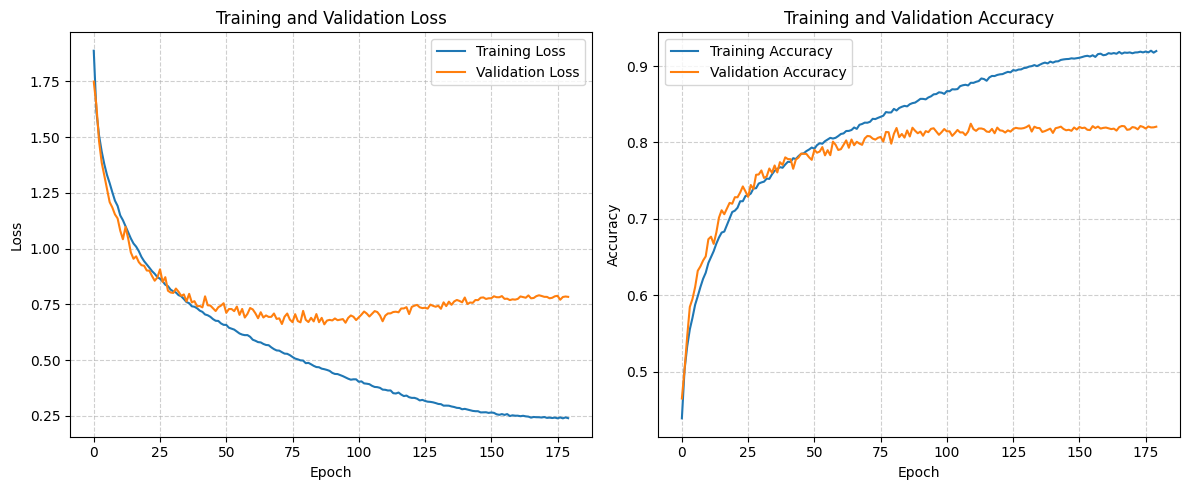

In [16]:
# Train model
trained_model, history = train_vit(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    num_epochs=180,
    learning_rate=0.001,
    weight_decay=5e-3,
    device=device
)

In [17]:
# Save the trained model
torch.save(trained_model.state_dict(), 'vit_tiny_32x32.pth')

# Evaluate on test set
test_accuracy, _ = evaluate_model(trained_model, val_loader, device)

print(f"Final test accuracy: {test_accuracy:.4f}")

Evaluating:   0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 0.8211
Final test accuracy: 0.8211
